In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
from erddapy import ERDDAP
import json

Configure the ERDDAP to search

In [2]:
ra = 'aoos'

with open('utils/ra_erddaps.json') as f:
    urls = json.load(f)

server = urls[ra.lower()]

print(server)

e = ERDDAP(server=server, protocol="tabledap")

http://erddap.aoos.org/erddap


Pull in the processed inventory

In [3]:
#
# df_cruise = df[df['Station Description'] == 'Chesapeake Bay WQ Cruise Data ']
#
#df_aws = df[df['Station ID'] == 'Humboldt']
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/OMOECC_E1/OMOECC_E1.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/45186/45186.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/bgsusd2/bgsusd2.ncml'
# url = 'http://oos.soest.hawaii.edu/thredds/dodsC/hioos/nss/ns12agg'
# print(url)
# ds = xr.open_dataset(url)
# #ds = netCDF4.Dataset(url,'r')
# title = ds.title
# start_time = np.datetime_as_string(ds.time.min().values, unit='D')
# end_time = np.datetime_as_string(ds.time.max().values, unit='D')
# print('Duration: %s - %s' % (np.datetime_as_string(ds.time.min().values, unit='D'),
#                              np.datetime_as_string(ds.time.max().values, unit='D'))
#       )

# Try glos web server
# url = 'https://glbuoys.glos.us/tools/export?ftype=csv&data_type=buoy&units=eng&locs=OMOECC_E1&params=Water_Temperature_at_Surface|dissolved_oxygen_saturation|water_conductivity|ysi_turbidity&tperiod=custom&date_start=2020-01-01&date_end=2020-12-31&avg_ivld=none'
# df = erddapy.ERDDAP.to_pandas(url)

## using ERDDAP to look for stations
# check out http://data.glos.us/erddap/tabledap/allDatasets.htmlTable?datasetID%2Ctitle%2CminTime%2CmaxTime&maxTime%3E=2020-01-01&maxTime%3C=2020-12-31&orderBy(%22maxTime%22)
# that lists out all the GLOS stations with the maximum time of observations within the year 2020 (on their ERDDAP).

df = pd.read_excel('2021/data/processed/%s.xlsx' % ra.upper(), dtype=str)
df

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes
0,AOOS,CSESM,NaN,Chukchi Sea Ecosystem Mooring (CSESM) Array,Hannah Shoal subsurface ecosystem mooring; Sea...,71.6,-161.5,moored_buoy,2015-09-01 00:00:00,Y,"AOOS, NPRB, UAF, others",Yp,UAF_CFOS,Academic,UAF,AOOS,"sea_water_temperature (35m, 48m, near-bottom),...",Rotated Annually. ~1 year lag on data ingesti...
1,AOOS,urn:ioos:station:org.gulfwatchalaska:GAK1,NaN,Oceanographic Station GAK1,Longterm non-realtime physcial parameters moor...,59.845,-149.466667,moored_buoy,1905-06-20 00:00:00,Y,"UAF, Exxon Valdez Oil Spill Trustees Council, ...",N,UAF_CFOS,Academic,UAF CFOS,"UAF, AOOS","NOT REAL TIME: sea_water_temperature (30 m, 60...",Subsurface mooring collecting CTD paramaters; ...
2,AOOS,urn:ioos:station:org.mxak:AKUTAN_WX,NaN,"Akutan, Port",WEATHER (no AIS); AIS LOCATED AT DIFFERENT SPOT,54.1321,-165.7818,Fixed,06/14/17; 7/26/2017,Y,AOOS,Yf,Marine Exchange of Alaska,nonprofit,MXAK (Marine Exchange of Alaska),AOOS,"dew_point_temperaure, air_temperature, air_pre...",need to cross check station
3,AOOS,urn:ioos:station:org.mxak:ANCHORAGE_PORT,NaN,Anchorage Port,AIS TRANSCEIVER WITH WEATHER,61.238746,-149.888778,Fixed,2015-05-05 00:00:00,Y,AOOS,Yf,Marine Exchange of Alaska,nonprofit,MXAK (Marine Exchange of Alaska),AOOS,"dew_point_temperaure, air_temperature, air_pre...",NaN
4,AOOS,org_mxak_bethel,NaN,Bethel,Weather (not sure if there is AIS there),60.7915,-161.7487,Fixed,2019-12-28 00:00:00,Y,AOOS,Yp,Marine Exchange of Alaska,nonprofit,MXAK (Marine Exchange of Alaska),AOOS,"dew_point_temperaure, air_temperature, air_pre...",New in 2019 but AOOS not reporting until 2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,AOOS,nelson-lagoon-outer-wave-buoy,New 2021,Nelson Lagoon (Outer) Wave Buoy,SOFAR Spotter Wave Buoy - Nelson Lagoon Commun...,56.0013,-161.212,Moored Buoy,11/14/2021 (need to get install date),"Y, O (seasonal)",EPA IGAP,N,Nelson Lagoon (commumity) and UAF (Chris Maio),"Academic, Private",Nelson Lagoon Community and UAF- Arctic Coasta...,SOFAR OCEAN,"sea_surface_wave_significant_height, sea_surfa...","These are seasonal buoy deployments, and this ..."
88,AOOS,naknek-wave-buoy,New 2021,Naknek Wave Buoy,SOFAR Spotter Wave Buoy in Naknek Harbor,58.6191,-157.3527,Moored Buoy,11/14/2021 (need to get install date),"Y, O (seasonal)",Alaska Sea Grant - NOAA,N,UAF-Arctic Coastal Geoscience Lab (Chris Maio),Academic,UAF-Arctic Geoscience Lab,SOFAR OCEAN,"sea_surface_wave_significant_height, sea_surfa...",This is a seasonal buoy deployment. Plan to re...
89,AOOS,dillingham-wave-buoy,New 2021,Dillingham Wave Buoy,SOFAR Spotter Wave Buoy in Dillingham Harbor,59.0224,-158.5104,Moored Buoy,2021-05-25 00:00:00,"Y, O (seasonal)",Alaska Sea Grant - NOAA,N,UAF-Arctic Coastal Geoscience Lab (Chris Maio),Academic,UAF-Arctic Geoscience Lab,SOFAR OCEAN,"sea_surface_wave_significant_height, sea_surfa...",This is a seasonal buoy deployment.Unfortuante...
90,AOOS,skan-bay-inner-wave-buoy,New 2021,Skan Bay Inner Wave Buoy,SOFAR Spotter Wave Buoy in Skan Bay (inner bay),53.6151,-167.0489,Moored Buoy,2021-08-27 00:00:00,Y,Not Sure,N,UNCW-Coastal Ocean Research and Monitoring Pro...,Academic,UNCW,SOFAR OCEAN,"sea_surface_wave_significant_height, sea_surfa...",These buoys are intended to remain in water ye...


Search the ERDDAP server for a single station of interest - more of a test

In [4]:
# df['Station ID'].loc[df['Station ID'].isna()] = df.loc[df['Station ID'].isna(),'Dataset ID']

# df['Station ID']

In [5]:
df_wf = df[df['Station ID'] == 'ioos:station:TCOON:076']

# for SCCOOS need to search for 'Station Long Name' as 'Station ID' is NA for most entries
search_for = df_wf['Station ID'].to_string()

search_url = e.get_search_url(search_for=search_for, response="csv")

try:
    resp = pd.read_csv(search_url)
    print(resp['Station ID'])
except:
    pass

Rip through all the datasets in the inventory and see if they exist on the RA erddap. Process checks the following order:

1. `Station ID`, then 
2. `Station Long Name`, then
3. `WMO ID or NWS/CMAN ID`

We first check if the value is `nan`. If so, we punt as that will return all datasets from the ERDDAP service.

In [6]:
not_found = []
found = dict()

exclude = ' -gliders'

search_order = ['Station ID', 'Station Long Name', 'WMO ID or NWS/CMAN ID']

for search1 in df[search_order[0]].astype(str):
    
    if search1 == "nan":
        print("punting with station long name = nan\n")
        not_found.append(search1)
        continue
    
    try:
        print('searching \"%s\" = \"%s\"' % (search_order[0], search1))
        search_url = e.get_search_url(search_for=search1+exclude, response="csv")
        resp = pd.read_csv(search_url)
        
        print("Found \"%s\": %s" % (search1,resp['Dataset ID'].values.tolist()))
        
        found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
        
    except:
        
        print('no dataset matching \"%s\"' % search1)
        search2 = df.loc[df[search_order[0]] == search1, search_order[1]].values.tolist()[0]
        
        if search2 == "nan":
                print("punting with %s = nan\n" % search_order[1])
                not_found.append(search1)
                continue
                
        try:
            
            print('searching \"%s\" = \"%s\"' % (search_order[1], search2))
            search_url = e.get_search_url(search_for=search2+exclude, response="csv")
            resp = pd.read_csv(search_url)
            print("Found \"%s\": %s" % (search2,resp['Dataset ID'].values.tolist()))
            
            found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
            
        except:

            search3 = str(df.loc[df[search_order[0]] == search1, search_order[2]].values.tolist()[0])
            
            if search3 == "nan":
                print("punting with \"%s\" = nan\n" % search_order[2])
                not_found.append(search1)
                continue
            
            try:
                print('searching \"%s\" = \"%s\"' % (search_order[2], search3))
                search_url = e.get_search_url(search_for=search3+exclude, response="csv")
                resp = pd.read_csv(search_url)
                print("Found \"%s\": %s" % (search3,resp['Dataset ID'].values.tolist()))
                
                found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
                
            except:
                print("Couldn't find:", [search1, search2, search3])
                not_found.append(search1)
        
    print("\n")

searching "Station ID" = "CSESM"
no dataset matching "CSESM"
searching "Station Long Name" = "Chukchi Sea Ecosystem Mooring (CSESM) Array"
punting with "WMO ID or NWS/CMAN ID" = nan

searching "Station ID" = "urn:ioos:station:org.gulfwatchalaska:GAK1"
no dataset matching "urn:ioos:station:org.gulfwatchalaska:GAK1"
searching "Station Long Name" = "Oceanographic Station GAK1"
punting with "WMO ID or NWS/CMAN ID" = nan

searching "Station ID" = "urn:ioos:station:org.mxak:AKUTAN_WX"
no dataset matching "urn:ioos:station:org.mxak:AKUTAN_WX"
searching "Station Long Name" = "Akutan, Port"
Found "Akutan, Port": ['akutan-1', 'noaa_nos_co_ops_9462691', 'noaa_nos_co_ops_9462694', 'noaa_nos_co_ops_9462711', 'org_mxak_akutan_wx']


searching "Station ID" = "urn:ioos:station:org.mxak:ANCHORAGE_PORT"
no dataset matching "urn:ioos:station:org.mxak:ANCHORAGE_PORT"
searching "Station Long Name" = "Anchorage Port"
Found "Anchorage Port": ['org_mxak_anchorage_port', 'miscwebcam_11', 'gov_noaa_nws_hads_ddc

no dataset matching "urn:ioos:station:org.mxak:MENDENHALL_VALLEY"
searching "Station Long Name" = "Mendenhall Valley"
Found "Mendenhall Valley": ['org_mxak_mendenhall_valley']


searching "Station ID" = "midway-island"
Found "midway-island": ['midway-island']


searching "Station ID" = "urn:ioos:station:org.mxak:MXAK_OFFICE"
no dataset matching "urn:ioos:station:org.mxak:MXAK_OFFICE"
searching "Station Long Name" = "MXAK Office"
Found "MXAK Office": ['org_mxak_mxak_office', 'org_mxak_dutch_harbor_port_of']


searching "Station ID" = "urn:ioos:station:org.mxak:NAKED_ISLAND"
no dataset matching "urn:ioos:station:org.mxak:NAKED_ISLAND"
searching "Station Long Name" = "Naked Island"
Found "Naked Island": ['net_cvinternet_naked', 'org_mxak_naked_island', 'noaa_nos_co_ops_9454563']


searching "Station ID" = "urn:ioos:station:org.mxak:NIKISKI"
no dataset matching "urn:ioos:station:org.mxak:NIKISKI"
searching "Station Long Name" = "Nikiski"
Found "Nikiski": ['org_mxak_nikiski', 'gov_noaa_wate

Found "urn:ioos:station:gov.noaa.water:TNUA2": ['gov_noaa_water_tnua2']


searching "Station ID" = "urn:ioos:station:gov.usda.nrcs.wcc.snotel:1071"
no dataset matching "urn:ioos:station:gov.usda.nrcs.wcc.snotel:1071"
searching "Station Long Name" = "Esther Island, SNOTEL STATION"
Found "Esther Island, SNOTEL STATION": ['gov_usda_nrcs_sntl_1071']


searching "Station ID" = "urn:ioos:station:gov.usda.nrcs.wcc.snotel:1073"
no dataset matching "urn:ioos:station:gov.usda.nrcs.wcc.snotel:1073"
searching "Station Long Name" = "Mt Eyak, SNOTEL STATION"
Found "Mt Eyak, SNOTEL STATION": ['gov_usda_nrcs_sntl_1073']


searching "Station ID" = "urn:ioos:station:gov.usda.nrcs.wcc.snotel:1074"
no dataset matching "urn:ioos:station:gov.usda.nrcs.wcc.snotel:1074"
searching "Station Long Name" = "Nuchek, SNOTEL STATION (on McNeil River)"
punting with "WMO ID or NWS/CMAN ID" = nan

searching "Station ID" = "urn:ioos:station:gov.usda.nrcs.wcc.snotel:1075"
no dataset matching "urn:ioos:station:gov.usda.nrc

Print the stations that we couldn't find.

In [7]:
len(not_found)

16

In [8]:
len(found)

76

In [9]:
df.loc[df[search_order[0]].isna()]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes


In [11]:
df[df[search_order[0]].isin(not_found)]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes
0,AOOS,CSESM,NaN,Chukchi Sea Ecosystem Mooring (CSESM) Array,Hannah Shoal subsurface ecosystem mooring; Sea...,71.6,-161.5,moored_buoy,2015-09-01 00:00:00,Y,"AOOS, NPRB, UAF, others",Yp,UAF_CFOS,Academic,UAF,AOOS,"sea_water_temperature (35m, 48m, near-bottom),...",Rotated Annually. ~1 year lag on data ingesti...
1,AOOS,urn:ioos:station:org.gulfwatchalaska:GAK1,NaN,Oceanographic Station GAK1,Longterm non-realtime physcial parameters moor...,59.845,-149.466667,moored_buoy,1905-06-20 00:00:00,Y,"UAF, Exxon Valdez Oil Spill Trustees Council, ...",N,UAF_CFOS,Academic,UAF CFOS,"UAF, AOOS","NOT REAL TIME: sea_water_temperature (30 m, 60...",Subsurface mooring collecting CTD paramaters; ...
7,AOOS,urn:ioos:station:org.mxak:CAPTAINS_BAY,NaN,Captains Bay - Dutch Harbor,WEATHER (No AIS),53.842909,-166.583242,Fixed,2018-12-12 00:00:00,Y,AOOS,Yf,Marine Exchange of Alaska,nonprofit,MXAK (Marine Exchange of Alaska),AOOS,"dew_point_temperaure, air_temperature, air_pre...",NaN
8,AOOS,urn:ioos:station:org.mxak:DEAD_HORSE,NaN,"Deadhorse, Prudhoe Bay",AIS TRANSCEIVER WITH WEATHER,70.22235,-148.419267,Fixed,10/01/15; 9/30/2015,Y,AOOS,Yf,Marine Exchange of Alaska,nonprofit,MXAK (Marine Exchange of Alaska),AOOS,"dew_point_temperaure, air_temperature, air_pre...","AOOS webstie record starts September 15, 2015...."
17,AOOS,urn:ioos:station:org.mxak:GUSTAVUS,GUXA2,Gustavus Dock,AIS TRANSCEIVER WITH WEATHER,58.407733,-135.726317,Fixed,9/19/2014; 07/26/2017,Y,AOOS,Yf,Marine Exchange of Alaska,nonprofit,MXAK (Marine Exchange of Alaska),AOOS,"dew_point_temperaure, air_temperature, air_pre...",Need to check install date (2014) vs date AOOS...
18,AOOS,urn:ioos:station:org.mxak:HAINES,HAXA2,Haines Harbor,AIS TRANSCEIVER WITH WEATHER,59.234083,-135.441717,Fixed,09/01/15; 7/26/2017,Y,AOOS,Yf,Marine Exchange of Alaska,nonprofit,MXAK (Marine Exchange of Alaska),AOOS,"dew_point_temperaure, air_temperature, air_pre...",Need to check install date (2015) vs date AOOS...
19,AOOS,urn:ioos:station:org.mxak:HOMER_SPIT,HMSA2,Homer Spit (Homer Port),AIS TRANSCEIVER WITH WEATHER,59.60206,-151.417436,Fixed,2015-05-05 00:00:00,Y,AOOS,Yf,Marine Exchange of Alaska,nonprofit,MXAK (Marine Exchange of Alaska),AOOS,"dew_point_temperaure, air_temperature, air_pre...",NaN
26,AOOS,urn:ioos:station:org.mxak:KETCHIKAN,KEXA2,Ketichikan Harbor,Weather,55.3516,-131.6839,Fixed,2015-05-05 00:00:00,Y,AOOS,Yf,Marine Exchange of Alaska,nonprofit,MXAK (Marine Exchange of Alaska),AOOS,"dew_point_temperaure, air_temperature, air_pre...",NaN
37,AOOS,urn:ioos:station:org.mxak:NOME,NaN,"Nome WX, Port Breakwater",WEATHER (no AIS); AIS AT DIFFERENT NOME LOCALE,64.494037,-165.440035,Fixed,2017-07-26 00:00:00,Y,AOOS,Yf,Marine Exchange of Alaska,nonprofit,MXAK (Marine Exchange of Alaska),AOOS,"dew_point_temperaure, air_temperature, air_pre...",The weather station is called NOME WX. There i...
42,AOOS,urn:ioos:station:org.mxak:SAVOONGA,NaN,"Savoonga, St. Lawrence Island",Weather and AIS eATON/Transceiver,63.692645,-170.492243,Fixed,2019-05-31 00:00:00,Y,"AOOS, MXAK",Yp,Marine Exchange of Alaska,nonprofit,MXAK (Marine Exchange of Alaska),AOOS,"dew_point_temperaure, air_temperature, air_pre...",Stations with Transceivers can transmit weathe...


In [12]:
#found.pop('HTLPWES')
found

{'urn:ioos:station:org.mxak:AKUTAN_WX': {'Dataset ID': ['akutan-1',
   'noaa_nos_co_ops_9462691',
   'noaa_nos_co_ops_9462694',
   'noaa_nos_co_ops_9462711',
   'org_mxak_akutan_wx']},
 'urn:ioos:station:org.mxak:ANCHORAGE_PORT': {'Dataset ID': ['org_mxak_anchorage_port',
   'miscwebcam_11',
   'gov_noaa_nws_hads_ddcda04a',
   'gov_noaa_nws_hads_15cf67be',
   'gov_noaa_nws_hads_15d101ae',
   'gov_noaa_nws_hads_ddcd95d0',
   'gov_usgs_waterdata_15276000',
   'gov_usgs_waterdata_15275100',
   'noaa_nos_co_ops_9451826',
   'noaa_nos_co_ops_9459464',
   'noaa_nos_co_ops_9454573',
   'noaa_nos_co_ops_9450271',
   'noaa_nos_co_ops_9450862',
   'noaa_nos_co_ops_9458917',
   'noaa_nos_co_ops_9450544',
   'noaa_nos_co_ops_9455920',
   'gov_usda_nrcs_sntl_1070']},
 'org_mxak_bethel': {'Dataset ID': ['org_mxak_bethel']},
 'urn:ioos:station:org.mxak:CAPE_DECISION': {'Dataset ID': ['org_mxak_cape_decision',
   'gov_noaa_nws_cdea2']},
 'cape-spencer-1': {'Dataset ID': ['cape-spencer-1']},
 'urn:ioos

Check if the dataset has coverage for CY 2021

In [13]:
valid_datasets = []

for key in found:
    
    dataset_id = found[key]['Dataset ID']
    
    if len(dataset_id)>1:
        
        for dataset in dataset_id:
            
            e.dataset_id = dataset
    
            e.constraints = {
                 "time>=": "2021-01-01"
            }
        
            e.variables = ['time']
    
            try:
                df_data = e.to_pandas(parse_dates=True)
                valid_datasets.extend([key])
                
            except:
                pass

                #print("No data for 2021 for %s: dataset ID %s" % (key,e.dataset_id))

    else:
        
        e.dataset_id = dataset_id[0]
    
        e.constraints = {
                         "time>=": "2021-01-01"
                        }
        
        e.variables = ['time']
        
        try:
            
            df_data = e.to_pandas(parse_dates=True)

            valid_datasets.extend([key])

        except:
            pass

            #print("No data for 2021 for %s: dataset ID %s" % (key,e.dataset_id))

            
#for valid in sorted(set(valid_datasets)):
    
#     # drop qc vars
#     cols = [c for c in df_data.columns if 'qc' not in c]
#     cols = [c for c in cols if 'QARTOD' not in c]

#     df_data = df_data[cols]

#     # set index for plotting
#     df_data = df_data.set_index(df_data['time (UTC)'])

#     # plot
#     #df_data.plot(subplots=True, title=e.dataset_id,figsize=(20,20))

#     start_time = df_data['time (UTC)'].min()
#     end_time = df_data['time (UTC)'].max()

#     print('Dataset %s' % e.dataset_id)
#     print('Duration: %s - %s' % (start_time, end_time))

non_2021_datasets = found.keys() - sorted(set(valid_datasets))

print('Datasets without coverage for 2021:\n%s' % non_2021_datasets)

Datasets without coverage for 2021:
set()


Show me the inventory metadata about the invalid stations:

In [14]:
bad_stations = df.loc[(df[search_order[0]].isin(non_2021_datasets)) | df[search_order[0]].isin(not_found)]

df['erddap_not_avail'] = df[search_order[0]].isin(bad_stations[search_order[0]])

In [15]:
df['erddap_not_avail']

0      True
1      True
2     False
3     False
4     False
      ...  
87    False
88    False
89    False
90    False
91    False
Name: erddap_not_avail, Length: 92, dtype: bool

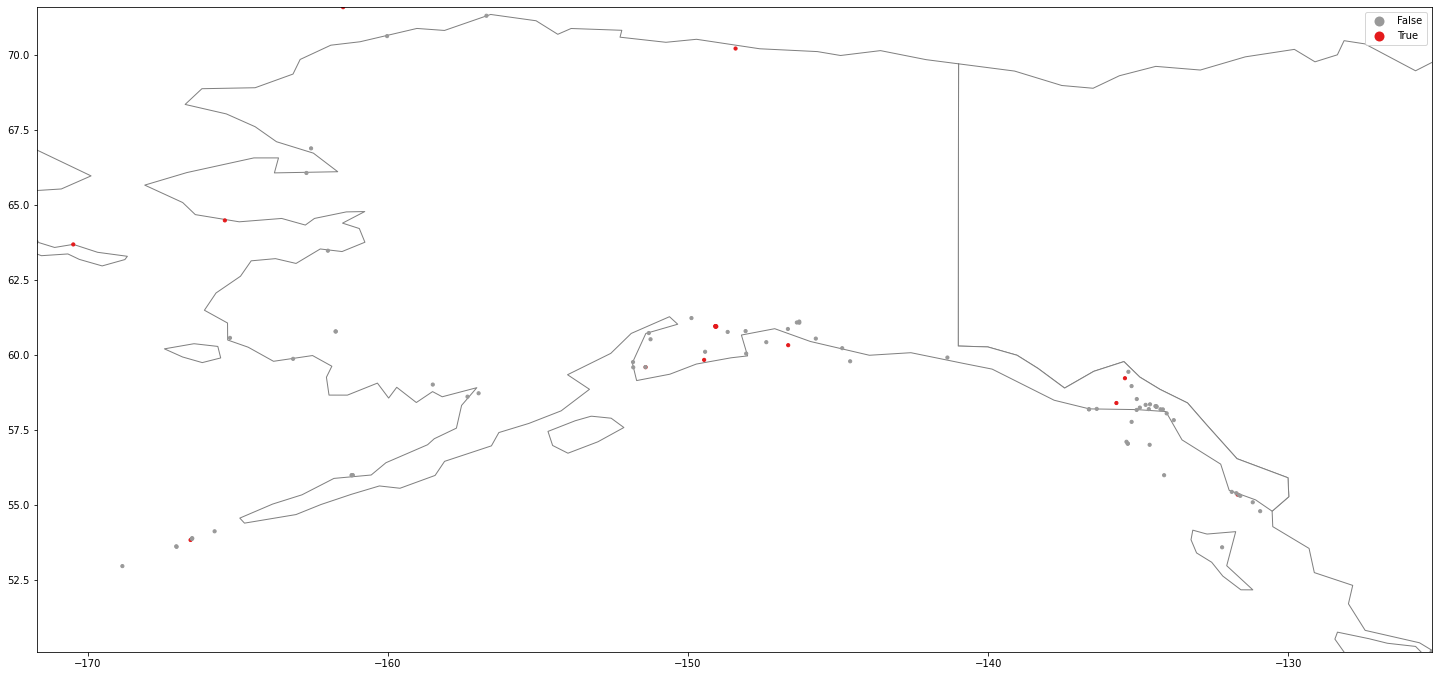

In [16]:
import geopandas
import matplotlib.pyplot as plt

#df = df.loc[df['']]

df.rename(columns=
{'Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].':
     'Variable Names',
 'Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)': 'Station Deployment',
 'Longitude (dec deg)': 'Longitude',
 'Latitude (dec deg)': 'Latitude'},
              inplace=True)

df['Station Deployment'] = \
    df['Station Deployment'].astype(str)


gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df['Longitude'], df['Latitude']))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='white', 
    edgecolor='grey', 
    figsize=(25,20),
    )

gdf.plot( ax=ax,
         column='erddap_not_avail', 
         categorical=True, 
         cmap = 'Set1_r',
         markersize=10, 
         legend=True,
         k=2,
        )



minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

plt.show()

In [17]:
gdf_final = gdf.set_crs(epsg=4326)

gdf_final.explore('erddap_not_avail',cmap = 'Set1_r',)

In [18]:
gdf_final.loc[gdf_final['geometry'].is_empty == True]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,erddap_not_avail,geometry


In [19]:
# import urllib.request
# for url in gdf_final.loc[gdf_final['erddap_not_avail'],'Station Description'].str.replace('url: ',''):
#     print(url)
#     try:
#         urllib.request.urlopen(url).getcode()
#     except:
#         print("URL broken: %s" % url)
#         print(gdf_final.loc[gdf_final['Station Description'].str.contains(url,regex=False),'Station ID'])

In [20]:
df.shape

(92, 20)

In [21]:
gdf_final['Station Description'].astype(str)

0     Hannah Shoal subsurface ecosystem mooring; Sea...
1     Longterm non-realtime physcial parameters moor...
2       WEATHER (no AIS); AIS LOCATED AT DIFFERENT SPOT
3                          AIS TRANSCEIVER WITH WEATHER
4              Weather (not sure if there is AIS there)
                            ...                        
87    SOFAR Spotter Wave Buoy - Nelson Lagoon Commun...
88             SOFAR Spotter Wave Buoy in Naknek Harbor
89         SOFAR Spotter Wave Buoy in Dillingham Harbor
90      SOFAR Spotter Wave Buoy in Skan Bay (inner bay)
91      SOFAR Spotter Wave Buoy in Skan Bay (outer bay)
Name: Station Description, Length: 92, dtype: object